In [1]:
%%time 
%reload_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from utils.imports import *
from utils.helpers import *
from utils.model import *

# instantiate model
device = 0
model, optimizer = load_train_objs(vocab_size, device, learning_rate)

# load val_data by crawling the list of wiki pages in "dataset/val_wiki.json"
world_size = torch.cuda.device_count()
val_data = load_val_data(device, world_size)
list_num_tokens, list_num_tokens_eval, list_losses, list_losses_eval = [], [], [], {'train':[], 'val':[]}


/data/home/osafak/.conda/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


num_params: 304 M
+---------+----------+---------+--------+------------+------------+----------------+---------------+
| d_model | n_layers | n_heads | d_head | block_size | batch_size | acc_batch_size | learning_rate |
+---------+----------+---------+--------+------------+------------+----------------+---------------+
|   1024  |    16    |    16   |   64   |    512     |     70     |    465920.0    |     3e-05     |
|         |          |         |        |            |   70/GPU   |                |               |
+---------+----------+---------+--------+------------+------------+----------------+---------------+
len(val_data):500000  (5 sec)
CPU times: user 42.5 s, sys: 6.81 s, total: 49.3 s
Wall time: 12.9 s


In [2]:
s0 = time.time()
directory = "/data/home/osafak/code/mygpt/dataset/multilingual-news"
PATH = f"{directory}/*.en*"
ls = glob.glob(PATH)
ls.sort(key=lambda x: x.split("/")[-1])
n_tokens = 0

fname = ls[2]
with open(fname, 'r') as f:
    text = f.read()
    print(f'"{fname.split("/")[-1]}": {len(text)/1e9:.3f} GB  {print_runtime(s0, False)}')

# # replace compatible characters with equivalents in English alphabet.
# text = unicodedata.normalize("NFKD", text)
# text = unidecode.unidecode(text)

# # clean up text. 
# text = clean_up(text, vocab)

# tokenize the text.
data = torch.tensor(encode(text), dtype=torch.long)
n_tokens += len(data)


with open(f'{fname}.json', 'w') as f:
    json.dump(data.tolist(), f)
    
    
print_runtime(s0)

"news.2008.en.shuffled":  4.388 GB  (1 min 13 sec)
Runtime: 12 min 36 sec


In [4]:
start = time.time()
step = 0
sample_no = 0
num_tokens = 0
num_batches = 0

myvalset = MyDataset(val_data, block_size)
val_loader = torch.utils.data.DataLoader(dataset=myvalset,
                                         batch_size=batch_size,
                                         shuffle=False)

list_losses_val.append(estimate_loss(model, val_loader, device))
list_num_tokens_val.append(num_tokens)
plotter(device, list_num_tokens, list_losses, list_num_tokens_val, list_losses_val, savefig=True)
generate_text(model, device, step, None) 

while step < max_iters:
    step += 1

    # crawl a new batch of wiki pages
    train_data, num_chars = crawl_wiki_data(device, new_links, visited_urls, num_chars, add//10)

    # wrap the data in DataLoader class. 
    mydataset = MyDataset(train_data, block_size)
    train_loader = torch.utils.data.DataLoader(
        dataset=mydataset,
        batch_size=batch_size,
        shuffle=False,
    )

    for batch_no, (xb, yb) in enumerate(train_loader):
        xb = xb.to(device)
        yb = yb.to(device)
        mb1 = xb.element_size() * xb.nelement() * 1e-6
        mb2 = yb.element_size() * yb.nelement() * 1e-6
        logits, loss = model(xb, yb) # evaluate the loss
        print(f'batch_no:{batch_no+1} of {len(train_loader)},  loss:{loss.item():.2f}, Memory:{mb1 + mb2}MB ', end='\r')
        loss = loss.mean() # take average across the 8 GPUs
        optimizer.zero_grad(set_to_none=True)
        loss.backward() # get the gradients with backprop.
        optimizer.step() # apply the gradient on the network parameters.
        list_losses.append(loss.item())
        num_tokens += block_size * batch_size 
        list_num_tokens.append(num_tokens)

        # evaluate at fixed intervals
        if step % eval_steps == 0 and batch_no == (len(train_loader) - 1):
            print(f'step:{step:3d}')
            out = estimate_loss(model, val_data, val_data)
            list_losses_eval['train'].append(out['train'])
            list_losses_eval['val'].append(out['val'])
            list_num_tokens_eval.append(num_tokens)
            plotter(list_num_tokens, list_losses, list_num_tokens_eval, list_losses_eval, savefig=True)
            generate_text(model) 


    print(f'step:{step:3d} num_pages:{len(visited_urls):02d}  '+
          f'{"FINISHED " if step == max_iters else ""} train():{print_runtime(start, False)}', end ='\n')


TypeError: crawl_wiki_data() missing 1 required positional argument: 'add'

In [ ]:
# train loop
train(model, optimizer, device, num_chars, val_data, 
      list_num_tokens, list_losses, list_num_tokens_eval, list_losses_eval, eval_steps)


In [ ]:
plotter(list_num_tokens, list_losses, list_num_tokens_eval, list_losses_eval)
generate_text(model)


# todo 
- Check if we're doing DDP across 8 GPUs correctly.
- check if `batch_size` designates number of batches per each GPU or the total batches of 8 GPUs.
- ~`get_batches` should get partial batches if it runs out of sentences~
- `get_batches` should process one wiki page at a time. 
- Use `tiktoken` tokenizer


# The Mathematical Trick in Self-Attention

- Attention is a **communication mechanism**. It's nodes in a graph looking at each other and aggregating information with a weighted sum from all nodes pointing to them  

- No notion of space. Attention itself only acts over nodes and vectors.

- Separate batches don't talk to each other. Each example across batch dimension is processed independently. 

- **Encoder:**  No masking with `tril` allowing all tokens to communicate. **Decoder** uses masking in an autoregressive settings so past tokens don't talk to future tokens --otherwise they would give away the answer.

- **Self-Attention:** keys, queries and values arecome from the same source. 
- **Cross-Attention:** queries are produced from x, keys and values are produced from a previous encoder module. Encoder encodes some context we want the decoder's generation process to be conditioned on.
- **Scaling by sqrt(d):** It's an important normalization to have. 


----
## 1. Experiments

In [143]:
tokenizer = 'gpt2'
print(f'tokenizer: {tokenizer}')
encFunc = ENCODING_CONSTRUCTORS['gpt2']
encDict = encFunc()
enc = tiktoken.Encoding(encDict['name'],
                        pat_str=encDict['pat_str'],
                        mergeable_ranks=encDict['mergeable_ranks'],
                        special_tokens=encDict['special_tokens' ])
vocab_size = enc.n_vocab
encode = enc.encode
decode = enc.decode

with open('dataset/tiny_shakespeare.txt', 'r') as f:
    text = f.read()
len(encode(text))

tokenizer: gpt2


In [213]:
dir(ax00)

['ArtistList',
 '_AxesBase__clear',
 '_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autotitlepos',
 '_axes',
 '_axes_locator',
 '_axis_map',
 '_axis_names',
 '_axisbelow',
 '_box_aspect',
 '_callbacks',
 '_check_no_units',
 '_children',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_colorbars',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_errorevery_to_mask',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_fully_clipped_to_axes',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spine

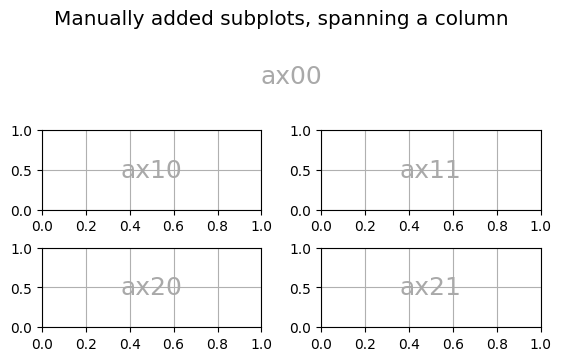

In [214]:
def annotate_axes(ax, text, fontsize=18):
    ax.text(0.5, 0.5, text, transform=ax.transAxes,
            ha="center", va="center", fontsize=fontsize, color="darkgrey")
    
    
fig = plt.figure(figsize=(5.5, 3.5), layout="constrained")
spec = fig.add_gridspec(3, 2)

ax00 = fig.add_subplot(spec[0, :])
ax00.grid(False)
ax00.set_axis_off()
annotate_axes(ax00, 'ax00')

ax10 = fig.add_subplot(spec[1, 0])
annotate_axes(ax10, 'ax10')

ax11 = fig.add_subplot(spec[1, 1])
annotate_axes(ax11, 'ax11')

ax20 = fig.add_subplot(spec[2, 0])
annotate_axes(ax20, 'ax20')

ax21 = fig.add_subplot(spec[2, 1])
annotate_axes(ax21, 'ax21')


fig.suptitle('Manually added subplots, spanning a column');


In [86]:
with open('dataset/scraped_urls.json', 'r') as f:
    scraped_urls = json.load(f)
len(scraped_urls) - 350100 * 7

4

In [124]:
# with open('dataset/wiki_text.txt','w')  as f:
#     f.write('')

with open('dataset/wiki_text.txt','a')  as f:
    json.dump([1,2,3], f)
    f.write(', ')


In [125]:
with open('dataset/wiki_text.txt','r')  as f:
    a = json.load(f)
a

JSONDecodeError: Extra data: line 1 column 10 (char 9)

In [ ]:
(0, 0.1), (x0, 1)
y = m * x + c

y = m * x + c
1 = m * x0 + 0.1
m = (1 - c) / x0




(0.0, 1.0449998575677009)

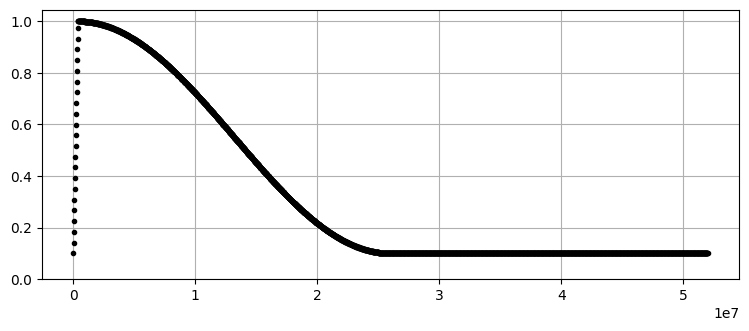

In [56]:

c = 0.065
x1 = x1 // 3
m = (1 - c) / x1 * x


y = m * x + c



x0 = .375e6
x1 = 26e6

for x in np.linspace(0, 2*x1, 3001):
    if x < x0:
        y = .9 * x / x0 + 0.1 
    elif x0 <= x < x1:
        b = 9 / (x1 - x0)
        a = (x0 * (1 - b)) / b 
        y = 1 / (b*(x + a) - x0 + 1) 
        
        T = (x1 - x0) * 2
        A = .5 * .9
        y = A * np.cos(2 * np.pi * (x - x0) / T) + 0.55    
    elif x1 <= x:
        y = .1

    plt.plot(x, y, 'k.')

plt.ylim(0)




In [283]:
from torch import distributed as dist 

dist.all_gather_object??

In [29]:
tokens = np.random.choice(range(enc.n_vocab), 100)
for tok in (tokens):
    print(f'{tok:6d} "{enc.decode([tok])}"')
    
text = enc.decode(tokens)
print(text)

 20495 " starring"
 49411 " trout"
 40089 " Carlo"
  7319 " thousand"
 43220 "cour"
 19096 " bracket"
 32294 " Jiang"
 34496 " Astral"
 35423 " realms"
 38467 " fungi"
 26555 " triggering"
 32908 " hairs"
 32511 "ojure"
 26124 "design"
 39232 "Repl"
  8614 " ||"
 43185 " pioneered"
 33676 "ROM"
 32261 " gag"
 48823 " Portsmouth"
 42666 " babe"
 41142 " Dracula"
 35291 "ervatives"
 42843 " Seymour"
 47958 " Whitman"
 35989 " 243"
  1283 " seem"
 10621 "eals"
 18953 " malware"
 32515 "pixel"
  4533 "ado"
 13744 "incial"
  2803 " estab"
  5815 "ÃÂÃÂ"
  1470 "raph"
 48663 " Aki"
 46700 "FIL"
 46622 " failings"
 22212 " Hex"
 37095 " unilateral"
 46115 "require"
 46193 " Detention"
 15716 " Vent"
 48352 " Louie"
 35556 " fascination"
 14615 " deciding"
 42013 " redeemed"
 24876 "Eye"
 34151 " Reef"
 29206 " eg"
 26442 "DAY"
 12849 " Size"
 22257 " Abe"
 19408 " Arrow"
  7919 "prise"
 36046 "Jump"
 20098 "rentice"
 41717 " 660"
  9245 " kiss"
 20317 "ū"
   844 "ix"
  9282 "archy"
 36508 " Le

In [38]:
import tiktoken 
from tiktoken_ext.openai_public import ENCODING_CONSTRUCTORS
encFunc = ENCODING_CONSTRUCTORS['gpt2']
encDict = encFunc()
enc = tiktoken.Encoding(encDict['name'],
                        pat_str=encDict['pat_str'],
                        mergeable_ranks=encDict['mergeable_ranks'],
                        special_tokens=encDict['special_tokens' ])
import torch
vocab_size = enc.n_vocab

idx = torch.ones((1,1), dtype=torch.long) * 35

tokens = enc.encode('Action') 
print(tokens)
for item in tokens:
    print(enc.decode([item])) 

[12502]
Action


In [8]:
seed_text = 'Into the flood again'
seed_tokens = enc.encode(seed_text)
seed_tokens = torch.as_tensor([seed_tokens], device=0, dtype=torch.long)
seed_tokens

tensor([[5317,   78,  262, 6947,  757]], device='cuda:0')

In [35]:
torch.ones((1,1), dtype=torch.long) * 35

tensor([[35]])

In [13]:
url = new_links.pop(0)
# shuffle new_links in place
random.shuffle(new_links)

text, html, num_chars = extract_single_url(url, visited_urls, num_chars)
new_links.extend(get_links(html, new_links, visited_urls))
train_data.append(torch.tensor(encode(text), dtype=torch.long))


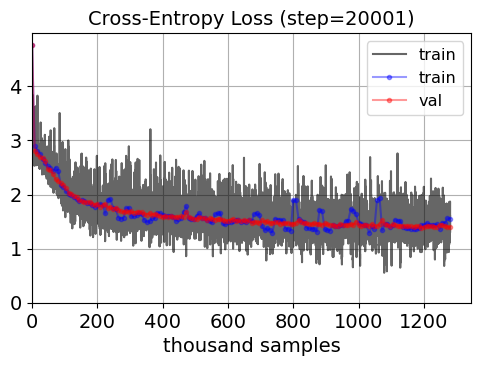

In [111]:
plotter(list_num_tokens, list_losses, list_num_tokens_eval, list_losses_eval, savefig=True)


## 2. Experiments
---

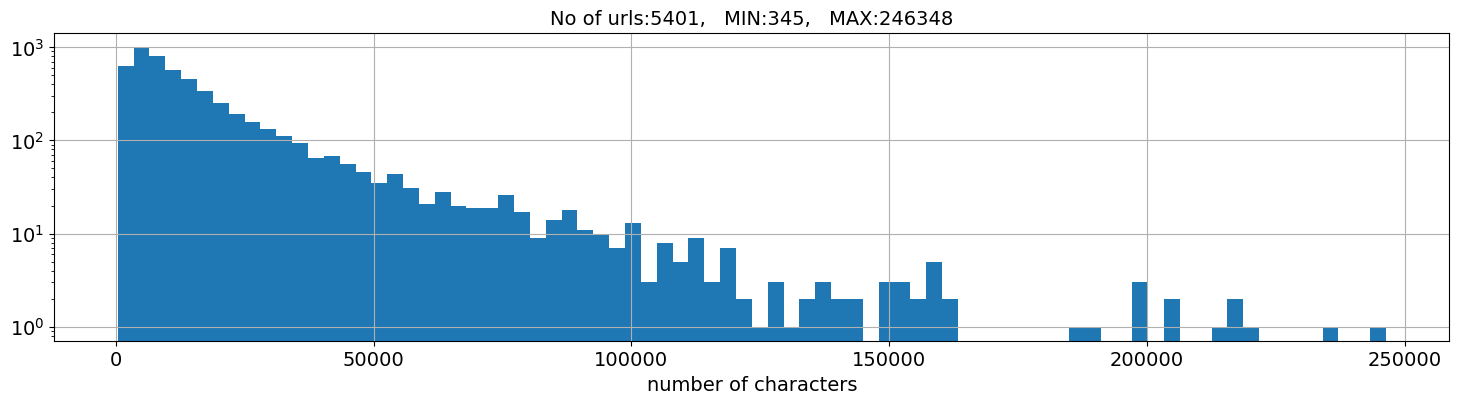

In [2]:
dirname='dataset/repo_wiki/'
fnames = sorted(glob.glob(f'{dirname}/*pkl'))
wikis = dict()
for fname in fnames:
    with open(fname, 'rb') as f:
        wikis.update(pickle.load(f)) 

urls = list(wikis.keys())
out = [(len(wikis[url])) for url in (urls)]
x, y, patches  = plt.hist(out, bins=80, log=True); plt.xlabel('number of characters'); 
plt.title(f'No of urls:{len(urls)},   MIN:{min(out)},   MAX:{max(out)}');


/data/home/osafak/.conda/envs/pt_env/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/data/home/osafak/.conda/envs/pt_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


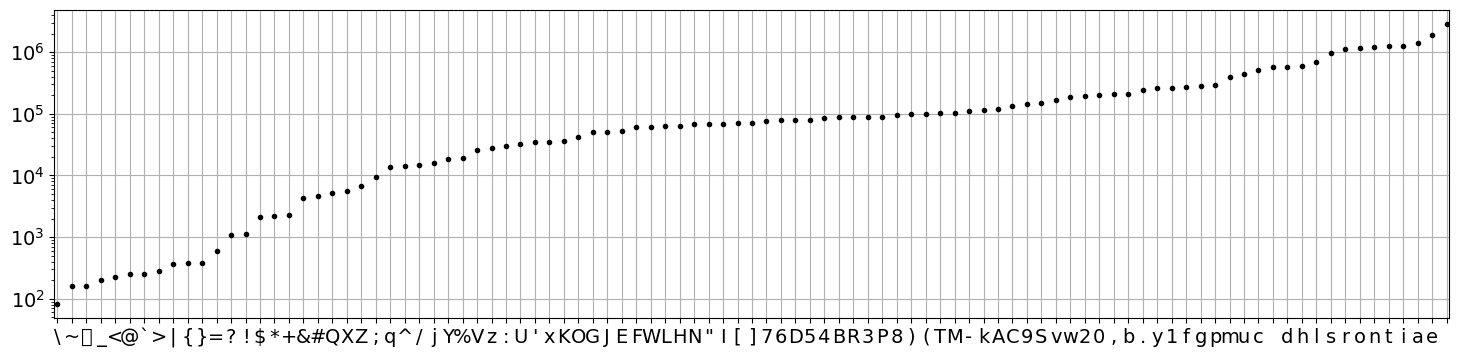

In [3]:
cnt = plot_character_frequency(urls[:1000], wikis)